# In this notebook we visualize effects of inserting a single CTCF in multiple backgrounds

In [3]:
import bioframe
import pandas as pd
import numpy as np
import tensorflow as tf
from basenji import dna_io
import akita_utils
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import h5py
# sns.set_theme()
import akita_utils.format_io

# Importing scores from simulations

In [2]:
def load_data(h5_dirs, scd_stats, models=[1]):
    
    model_dfs = {} 
    for h5_num, h5_file in enumerate(glob.glob(h5_dirs)):
        
        for model in models:
            if f"model{model}_h" in h5_file:  
                df = akita_utils.format_io.h5_to_df(h5_file, scd_stats, drop_duplicates_key=None)
                if f"model{model}" in model_dfs.keys():
                    model_dfs[f"model{model}"] = pd.concat([model_dfs[f"model{model}"], df])
                else:
                    model_dfs[f"model{model}"] = df  
            
    # merged_df = pd.DataFrame()
    for df_num,df in enumerate(model_dfs.values()):
        if df_num ==0:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on=['CTCF_1_insert',"background_seqs"], how='inner', suffixes=("",f"_{df_num}"))
    
    if 'merged_df' not in locals():
        print("Error: merged_df is empty. Cannot perform further calculations.")
        exit(1)
    else:
        for stat in scd_stats:
            for model in models:
                merged_df[f"mean_{stat}_score_m{model}"] = (
                      merged_df[f"{stat}_h1_m{model}_t0"]
                    + merged_df[f"{stat}_h1_m{model}_t1"]
                    + merged_df[f"{stat}_h1_m{model}_t2"]
                    + merged_df[f"{stat}_h1_m{model}_t3"]
                    + merged_df[f"{stat}_h1_m{model}_t4"]
                    + merged_df[f"{stat}_h1_m{model}_t5"]
                ) / 6

            # Calculate mean score over models for current statistic
            mean_score = np.mean([
                merged_df[f"mean_{stat}_score_m{model}"] for model in models
            ], axis=0)

            # Add mean score column to DataFrame
            merged_df[f"mean_{stat}_score"] = mean_score

        return merged_df.reset_index(drop=True)


In [3]:
uniformly_selcted_model2_motifs_h5_dirs = (
 # "/scratch1/kamulege/insert_experiments/12_uniformly_selcted_model2_motifs/*/*/*.h5"
    "/scratch1/kamulege/insert_experiments/11_uniformly_selcted_model6_motifs_v2/*/*/*.h5"
)

uniformly_selcted_model2_motifs_df = load_data(uniformly_selcted_model2_motifs_h5_dirs, scd_stats=["SCD", "SSD"], models=[2,3,4,5,6,7])

uniformly_selcted_model2_motifs_df

,CTCF_1_genomic_SCD,CTCF_1_insert,SCD_h1_m3_t0,SCD_h1_m3_t1,SCD_h1_m3_t2,SCD_h1_m3_t3,SCD_h1_m3_t4,SCD_h1_m3_t5,SSD_h1_m3_t0,SSD_h1_m3_t1,...,mean_SCD_score_m6,mean_SCD_score_m7,mean_SCD_score,mean_SSD_score_m2,mean_SSD_score_m3,mean_SSD_score_m4,mean_SSD_score_m5,mean_SSD_score_m6,mean_SSD_score_m7,mean_SSD_score
0,61.880,"chr7,118307881,118307900,-,20,0,>",0.094299,0.102417,0.066345,0.062500,0.071960,0.059937,0.094299,0.102417,...,0.384521,0.453857,0.229004,0.161865,0.076233,0.128296,0.168945,0.384521,0.453857,0.229004
1,61.880,"chr7,118301143,118301162,-,20,0,>",0.854492,1.073242,0.616211,0.586426,0.731445,0.582520,0.854492,1.073242,...,1.366211,4.550781,1.746094,0.737793,0.740234,1.000977,2.080078,1.366211,4.550781,1.746094
2,61.800,"chr7,118301288,118301307,+,20,0,>",0.060364,0.062073,0.046997,0.043823,0.046265,0.040039,0.060364,0.062073,...,0.303955,0.198608,0.136108,0.092590,0.049927,0.087219,0.084045,0.303955,0.198608,0.136108
3,61.720,"chr7,118302080,118302099,+,20,0,>",0.101257,0.124939,0.094849,0.090820,0.095642,0.082764,0.101257,0.124939,...,0.233032,0.318604,0.160034,0.104187,0.098328,0.096619,0.109131,0.233032,0.318604,0.160034
4,54.300,"chr1,5905663,5905682,-,20,0,>",0.041718,0.052338,0.039520,0.037079,0.040619,0.033539,0.041718,0.052338,...,0.191772,0.835449,0.210205,0.072510,0.040802,0.066101,0.054901,0.191772,0.835449,0.210205
5,54.250,"chr1,5905410,5905429,+,20,0,>",0.114014,0.142700,0.101990,0.096680,0.106689,0.087830,0.114014,0.142700,...,0.157593,0.135132,0.110596,0.096130,0.108398,0.055756,0.110535,0.157593,0.135132,0.110596
6,32.970,"chr12,80724993,80725012,-,20,0,>",33.750000,43.500000,25.359375,24.828125,31.359375,24.328125,33.750000,43.500000,...,31.875000,30.437500,31.671875,27.109375,30.515625,28.625000,41.500000,31.875000,30.437500,31.671875
7,32.900,"chr12,80722104,80722123,-,20,0,>",0.132935,0.139893,0.139160,0.129883,0.126831,0.111389,0.132935,0.139893,...,0.205078,0.230469,0.150513,0.121643,0.130005,0.079102,0.137085,0.205078,0.230469,0.150513
8,32.900,"chr12,80721634,80721653,-,20,0,>",0.589844,0.719727,0.451172,0.422852,0.506348,0.407471,0.589844,0.719727,...,0.420654,1.855469,0.785645,0.651855,0.516113,0.460205,0.808594,0.420654,1.855469,0.785645
9,32.880,"chr12,80729003,80729022,+,20,0,>",7.433594,9.156250,3.611328,3.521484,5.414062,4.214844,7.433594,9.156250,...,8.273438,5.511719,4.863281,2.507812,5.558594,4.207031,3.119141,8.273438,5.511719,4.863281


In [4]:
# uniformly_selcted_model1_motifs_h5_dirs = (
#  "/scratch1/kamulege/insert_experiments/1000_uniformly_selcted_model1_motifs/*/*/*.h5"
# )

# uniformly_selcted_model1_motifs_df = load_data(uniformly_selcted_model1_motifs_h5_dirs, scd_stats=["SCD", "SSD"], models=[1])

# uniformly_selcted_model1_motifs_df

In [5]:
motifs_df = uniformly_selcted_model2_motifs_df

motifs_df.columns

Index(['CTCF_1_genomic_SCD', 'CTCF_1_insert', 'SCD_h1_m3_t0', 'SCD_h1_m3_t1',
       'SCD_h1_m3_t2', 'SCD_h1_m3_t3', 'SCD_h1_m3_t4', 'SCD_h1_m3_t5',
       'SSD_h1_m3_t0', 'SSD_h1_m3_t1', 'SSD_h1_m3_t2', 'SSD_h1_m3_t3',
       'SSD_h1_m3_t4', 'SSD_h1_m3_t5', 'background_seqs',
       'CTCF_1_genomic_SCD_1', 'SCD_h1_m2_t0', 'SCD_h1_m2_t1', 'SCD_h1_m2_t2',
       'SCD_h1_m2_t3', 'SCD_h1_m2_t4', 'SCD_h1_m2_t5', 'SSD_h1_m2_t0',
       'SSD_h1_m2_t1', 'SSD_h1_m2_t2', 'SSD_h1_m2_t3', 'SSD_h1_m2_t4',
       'SSD_h1_m2_t5', 'CTCF_1_genomic_SCD_2', 'SCD_h1_m7_t0', 'SCD_h1_m7_t1',
       'SCD_h1_m7_t2', 'SCD_h1_m7_t3', 'SCD_h1_m7_t4', 'SCD_h1_m7_t5',
       'SSD_h1_m7_t0', 'SSD_h1_m7_t1', 'SSD_h1_m7_t2', 'SSD_h1_m7_t3',
       'SSD_h1_m7_t4', 'SSD_h1_m7_t5', 'CTCF_1_genomic_SCD_3', 'SCD_h1_m6_t0',
       'SCD_h1_m6_t1', 'SCD_h1_m6_t2', 'SCD_h1_m6_t3', 'SCD_h1_m6_t4',
       'SCD_h1_m6_t5', 'SSD_h1_m6_t0', 'SSD_h1_m6_t1', 'SSD_h1_m6_t2',
       'SSD_h1_m6_t3', 'SSD_h1_m6_t4', 'SSD_h1_m6_t5', 'CTC

,CTCF_1_genomic_SCD,CTCF_1_insert,SCD_h1_m3_t0,SCD_h1_m3_t1,SCD_h1_m3_t2,SCD_h1_m3_t3,SCD_h1_m3_t4,SCD_h1_m3_t5,SSD_h1_m3_t0,SSD_h1_m3_t1,...,mean_SCD_score,mean_SSD_score_m2,mean_SSD_score_m3,mean_SSD_score_m4,mean_SSD_score_m5,mean_SSD_score_m6,mean_SSD_score_m7,mean_SSD_score,CTCF_1_genomic_SCD_norm,mean_SCD_score_norm
0,61.880,"chr7,118307881,118307900,-,20,0,>",0.094299,0.102417,0.066345,0.062500,0.071960,0.059937,0.094299,0.102417,...,0.229004,0.161865,0.076233,0.128296,0.168945,0.384521,0.453857,0.229004,1.000000,0.007229
1,61.880,"chr7,118301143,118301162,-,20,0,>",0.854492,1.073242,0.616211,0.586426,0.731445,0.582520,0.854492,1.073242,...,1.746094,0.737793,0.740234,1.000977,2.080078,1.366211,4.550781,1.746094,1.000000,0.055145
2,61.800,"chr7,118301288,118301307,+,20,0,>",0.060364,0.062073,0.046997,0.043823,0.046265,0.040039,0.060364,0.062073,...,0.136108,0.092590,0.049927,0.087219,0.084045,0.303955,0.198608,0.136108,0.998707,0.004299
3,61.720,"chr7,118302080,118302099,+,20,0,>",0.101257,0.124939,0.094849,0.090820,0.095642,0.082764,0.101257,0.124939,...,0.160034,0.104187,0.098328,0.096619,0.109131,0.233032,0.318604,0.160034,0.997414,0.005054
4,54.300,"chr1,5905663,5905682,-,20,0,>",0.041718,0.052338,0.039520,0.037079,0.040619,0.033539,0.041718,0.052338,...,0.210205,0.072510,0.040802,0.066101,0.054901,0.191772,0.835449,0.210205,0.877505,0.006638
5,54.250,"chr1,5905410,5905429,+,20,0,>",0.114014,0.142700,0.101990,0.096680,0.106689,0.087830,0.114014,0.142700,...,0.110596,0.096130,0.108398,0.055756,0.110535,0.157593,0.135132,0.110596,0.876697,0.003492
6,32.970,"chr12,80724993,80725012,-,20,0,>",33.750000,43.500000,25.359375,24.828125,31.359375,24.328125,33.750000,43.500000,...,31.671875,27.109375,30.515625,28.625000,41.500000,31.875000,30.437500,31.671875,0.532805,1.000000
7,32.900,"chr12,80722104,80722123,-,20,0,>",0.132935,0.139893,0.139160,0.129883,0.126831,0.111389,0.132935,0.139893,...,0.150513,0.121643,0.130005,0.079102,0.137085,0.205078,0.230469,0.150513,0.531674,0.004753
8,32.900,"chr12,80721634,80721653,-,20,0,>",0.589844,0.719727,0.451172,0.422852,0.506348,0.407471,0.589844,0.719727,...,0.785645,0.651855,0.516113,0.460205,0.808594,0.420654,1.855469,0.785645,0.531674,0.024811
9,32.880,"chr12,80729003,80729022,+,20,0,>",7.433594,9.156250,3.611328,3.521484,5.414062,4.214844,7.433594,9.156250,...,4.863281,2.507812,5.558594,4.207031,3.119141,8.273438,5.511719,4.863281,0.531351,0.153564


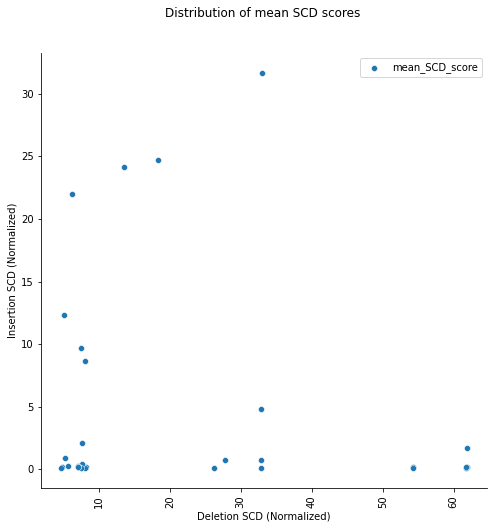

In [6]:
# normalize the data

max_ctcf = motifs_df['CTCF_1_genomic_SCD'].max()
max_mean_scd = motifs_df['mean_SCD_score'].max()
motifs_df['CTCF_1_genomic_SCD_norm'] = motifs_df['CTCF_1_genomic_SCD'] / max_ctcf
motifs_df['mean_SCD_score_norm'] = motifs_df['mean_SCD_score'] / max_mean_scd

# create the plot
fig, ax = plt.subplots(figsize=(8, 8)) #, dpi=200

# data = motifs_df[(motifs_df['mean_SCD_score_norm']>0.8) & (motifs_df['CTCF_1_genomic_SCD_norm']<0.5)]
data = motifs_df
display(data)

# sns.scatterplot(data=data, ax=ax, x="CTCF_1_genomic_SCD_norm", y="mean_SCD_score_norm", label="mean_SCD_score")
sns.scatterplot(data=data, ax=ax, x="CTCF_1_genomic_SCD", y="mean_SCD_score", label="mean_SCD_score")

sns.despine(top=True, right=True)
plt.xticks(rotation=90)
plt.title("Distribution of mean SCD scores \n \n ")

# Add bands for high and low correlation
# sns.regplot(data=motifs_df, ax=ax, x="CTCF_1_genomic_SCD_norm", y="mean_SCD_score_norm", scatter=False, color="red", label="High Correlation")
# sns.regplot(data=motifs_df, ax=ax, x="CTCF_1_genomic_SCD_norm", y="mean_SCD_score_norm", scatter=False, color="blue", label="Low Correlation")

plt.xlabel("Deletion SCD (Normalized)")
plt.ylabel("Insertion SCD (Normalized)")
plt.legend()
plt.show()



In [7]:
# [i for i in range(-1000,1050,50)]


In [8]:
# # Calculate correlation between two columns
# corr = df['column1'].corr(df['column2'])

# # Check if correlation coefficient is close to zero
# if abs(corr) < 0.1:
#     # Select corresponding points for further analysis
#     selected_points = df.loc[(df['column1'] == some_value) & (df['column2'] == some_other_value)]

In [9]:
def collect_h5(file_name, out_dir, num_procs):
    # count variants
    num_variants = 0
    for pi in range(num_procs):
        # open job
        job_h5_file = "%s/job%d/%s" % (out_dir, pi, file_name)
        job_h5_open = h5py.File(job_h5_file, "r")
        # print(job_h5_open)
        num_variants += len(job_h5_open["chrom"]) #chrom_core
        job_h5_open.close()

    # initialize final h5
    final_h5_file = "%s/%s" % (out_dir, file_name)
    final_h5_open = h5py.File(final_h5_file, "w")

    # keep dict for string values
    final_strings = {}

    job0_h5_file = "%s/job0/%s" % (out_dir, file_name)
    job0_h5_open = h5py.File(job0_h5_file, "r")
    for key in job0_h5_open.keys():
        if key in ["target_ids", "target_labels"]:
            # copy
            final_h5_open.create_dataset(key, data=job0_h5_open[key])

        elif job0_h5_open[key].dtype.char == "S":
            final_strings[key] = []

        elif job0_h5_open[key].ndim == 1:
            final_h5_open.create_dataset(
                key, shape=(num_variants,), dtype=job0_h5_open[key].dtype
            )

        else:
            num_targets = job0_h5_open[key].shape[1]
            final_h5_open.create_dataset(
                key, shape=(num_variants, num_targets), dtype=job0_h5_open[key].dtype
            )

    job0_h5_open.close()

    # set values
    vi = 0
    for pi in range(num_procs):
        # open job
        job_h5_file = "%s/job%d/%s" % (out_dir, pi, file_name)
        job_h5_open = h5py.File(job_h5_file, "r")

        # append to final
        for key in job_h5_open.keys():
            if key in ["target_ids", "target_labels"]:
                # once is enough
                pass

            else:
                if job_h5_open[key].dtype.char == "S":
                    final_strings[key] += list(job_h5_open[key])
                else:
                    job_variants = job_h5_open[key].shape[0]
                    final_h5_open[key][vi : vi + job_variants] = job_h5_open[key]

        vi += job_variants
        job_h5_open.close()

    # create final string datasets
    for key in final_strings:
        final_h5_open.create_dataset(key, data=np.array(final_strings[key], dtype="S"))

    final_h5_open.close()

In [11]:
# collect_h5("scd.h5", "/scratch1/kamulege/test_disruption_scd/motif_expt_model6_head1", 12)

collect_h5("scd.h5", "/scratch1/kamulege/test_disruption_scd_span_test/motif_expt_model7_head1/", 12)


In [82]:
h5_dirs_2 = "/scratch1/kamulege/test_disruption_scd/motif_expt_model1_head1/scd.h5"
h5_dirs_1 = "/project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model1/scd.h5"
sites_1 = akita_utils.tsv_gen_utils.filter_boundary_ctcfs_from_h5(
        h5_dirs=h5_dirs_1, score_key="SCD", threshold_all_ctcf=0,
    )
sites_2 = akita_utils.tsv_gen_utils.filter_boundary_ctcfs_from_h5(
        h5_dirs=h5_dirs_2, score_key="SCD", threshold_all_ctcf=0,
    )


annotating each site with boundary-wide scores
annotating each site with boundary-wide scores


17740
17642


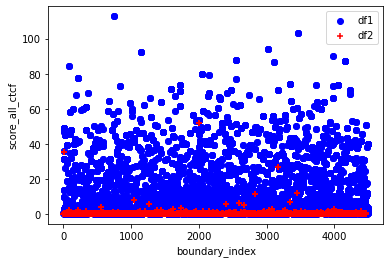

In [89]:
print(len(sites_1["score_all_ctcf"]))  
print(len(sites_2["score_all_ctcf"]))

# create a scatter plot for df1
plt.scatter(sites_1['boundary_index'], sites_1['score_all_ctcf'], label='df1', color='blue', marker='o')

# create a scatter plot for df2
plt.scatter(sites_2['boundary_index'], sites_2['score_all_ctcf'], label='df2', color='red', alpha=1, marker='+') 
# score_10k score_all_ctcf
plt.xlabel("boundary_index")
plt.ylabel("score_all_ctcf")
# plt.ylim(0,5)
plt.legend()

In [ ]:
score_key="SCD"
upper_threshold=99
lower_threshold=1
mode="head"

upper_thresh = np.percentile(sites[score_key].values, upper_threshold)
lower_thresh = np.percentile(sites[score_key].values, lower_threshold)

filtered_sites = (
    sites[(sites[score_key] >= lower_thresh) & (sites[score_key] <= upper_thresh)]
    .copy()
    # .drop_duplicates(subset=[score_key])
    .sort_values(score_key, ascending=False)
)

In [ ]:
len(filtered_sites)

In [12]:
df_1 = pd.read_csv('/project/fudenber_735/tensorflow_models/akita/v2/analysis/boundaries.motifs.ctcf.mm10.tsv', sep='\t')
df_2 = pd.read_csv('/scratch1/kamulege/boundaries.motifs.ctcf.mm10.tsv', sep='\t')
df_3 = pd.merge(df_1, df_2, on="start" )

In [70]:
not_in_df_2 = df_1[~df_1['span'].isin(df_2['span'])]

not_in_df_2

,chrom,start,end,span,score_2,strand_2,num_ctcf,log2_insulation_score_200000,boundary_strength_200000,boundary_index,index
1966,chr1,194600000,194610000,194602458-194602477,834.0,+,4,-0.1763,0.4216,361,1966
1967,chr1,194600000,194610000,194603383-194603402,827.0,-,4,-0.1763,0.4216,361,1967
1968,chr1,194600000,194610000,194607600-194607619,801.0,+,4,-0.1763,0.4216,361,1968
1969,chr1,194600000,194610000,194608059-194608078,872.0,+,4,-0.1763,0.4216,361,1969
1970,chr1,194600000,194610000,"194602458-194602477,194603383-194603402,194607...",NaN,NaN,4,-0.1763,0.4216,361,1970
...,...,...,...,...,...,...,...,...,...,...,...
26510,chr19,60750000,60760000,60753321-60753340,815.0,-,4,-0.6660,1.0220,4494,26510
26511,chr19,60750000,60760000,60753444-60753463,854.0,+,4,-0.6660,1.0220,4494,26511
26512,chr19,60750000,60760000,60756843-60756862,808.0,+,4,-0.6660,1.0220,4494,26512
26513,chr19,60750000,60760000,"60753302-60753321,60753321-60753340,60753444-6...",NaN,NaN,4,-0.6660,1.0220,4494,26513


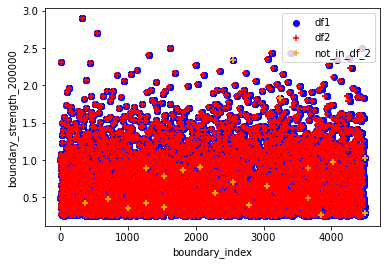

In [80]:
# df_3.plot.scatter(x='start_x', y='start_y')

# create a scatter plot for df1
plt.scatter(df_1['boundary_index'], df_1['boundary_strength_200000'], label='df1', color='blue', marker='o')

# create a scatter plot for df2
plt.scatter(df_2['boundary_index'], df_2['boundary_strength_200000'], label='df2', color='red', marker='+')

plt.scatter(not_in_df_2['boundary_index'], not_in_df_2['boundary_strength_200000'], label='not_in_df_2', color='orange', alpha=1, marker='+')

plt.xlabel("boundary_index")
plt.ylabel("boundary_strength_200000")
plt.legend()

In [40]:
df_1.shape[0] - df_2.shape[0]

129